In [2]:
import pandas as pd

df = pd.read_csv('../polygraphpy/data/polarizability_data.csv')
df = df[(df['chain_size'] == 0)]

df.describe()

,id,chain_size,xx,yy,zz,static_polarizability
count,9.208000e+03,9208.0,9208.000000,9208.000000,9208.000000,9208.000000
mean,6.529761e+07,0.0,182.101843,165.098919,193.269279,180.156681
std,5.045335e+07,0.0,83.794621,98.714967,94.820246,72.935720
min,3.248000e+03,0.0,4.334219,4.019532,0.185242,27.820679
25%,1.284903e+07,0.0,125.402667,90.467746,124.526352,127.535665
50%,6.727262e+07,0.0,171.540961,146.112978,180.371019,173.418787
75%,9.168526e+07,0.0,223.298835,222.982157,247.378887,218.825249
max,1.718551e+08,0.0,1186.513807,1047.835707,906.710499,808.095149


# Test 1: just atomic number

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GraphUNet
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import negative_sampling
from rdkit import Chem
from torchmetrics.classification import AUROC, AveragePrecision, Accuracy, F1Score

smiles_list = df['smiles'].values

# === Convert SMILES to Data ===
def smiles_to_data(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    x = torch.tensor([[atom.GetAtomicNum()] for atom in mol.GetAtoms()], dtype=torch.float)
    edge_index = torch.tensor([[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()] for bond in mol.GetBonds()],
                              dtype=torch.long).t().contiguous()
    edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1)  # Make undirected
    return Data(x=x, edge_index=edge_index)

# === Build Dataset ===
datas = [smiles_to_data(smiles) for smiles in smiles_list]
datas = [data for data in datas if data is not None and data.edge_index.size(1) > 0]
loader = DataLoader(datas, batch_size=64, shuffle=True)

# === Model Setup ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphUNet(in_channels=1, hidden_channels=32, out_channels=4, depth=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# === Training Loop ===
def train():
    model.train()
    total_loss = 0
    valid_batches = 0
    for batch in loader:
        if batch.edge_index.size(1) == 0:
            continue
        batch = batch.to(device)
        optimizer.zero_grad()

        z = model(batch.x, batch.edge_index)
        pos_edge_index = batch.edge_index

        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index,
            num_nodes=batch.num_nodes,
            num_neg_samples=pos_edge_index.size(1),
            method='sparse'
        )

        pos_score = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(1)
        neg_score = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(1)
        scores = torch.cat([pos_score, neg_score])
        labels = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)])

        loss = F.binary_cross_entropy_with_logits(scores, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        valid_batches += 1

    return total_loss / valid_batches if valid_batches > 0 else 0

# === Evaluation ===
def evaluate():
    model.eval()
    metrics = {"ROC-AUC": 0, "AP": 0, "Accuracy": 0, "F1": 0}
    valid_graphs = 0

    auroc = AUROC(task="binary").to(device)
    ap = AveragePrecision(task="binary").to(device)
    acc = Accuracy(task="binary").to(device)
    f1 = F1Score(task="binary").to(device)

    with torch.no_grad():
        for batch in loader:
            if batch.edge_index.size(1) == 0:
                continue
            batch = batch.to(device)
            z = model(batch.x, batch.edge_index)

            pos_edge_index = batch.edge_index
            neg_edge_index = negative_sampling(
                edge_index=pos_edge_index,
                num_nodes=batch.num_nodes,
                num_neg_samples=pos_edge_index.size(1),
                method='sparse'
            )

            pos_score = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(1)
            neg_score = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(1)
            scores = torch.cat([pos_score, neg_score]).sigmoid()
            labels = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)]).long()

            metrics["ROC-AUC"] += auroc(scores, labels).item()
            metrics["AP"] += ap(scores, labels).item()
            metrics["Accuracy"] += acc(scores, labels).item()
            metrics["F1"] += f1(scores, labels).item()
            valid_graphs += 1

    if valid_graphs > 0:
        for key in metrics:
            metrics[key] /= valid_graphs
    return metrics

# === Run Training ===
for epoch in range(300):
    loss = train()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.7f}")

# === Final Evaluation ===
metrics = evaluate()
print("Evaluation Metrics:")
for key, val in metrics.items():
    print(f"{key}: {val:.7f}")


/home/jgduarte/Documents/RA/Projects/3M/PolyGraphPy/.venv/lib/python3.13/site-packages/torch_geometric/utils/sparse.py:277: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  adj = torch.sparse_csr_tensor(


Epoch 0, Loss: 3.9372611
Epoch 10, Loss: 0.6182612
Epoch 20, Loss: 0.5888173
Epoch 30, Loss: 0.5742637
Epoch 40, Loss: 0.5710284
Epoch 50, Loss: 0.5693075
Epoch 60, Loss: 0.5695809
Epoch 70, Loss: 0.5686039
Epoch 80, Loss: 0.5672253
Epoch 90, Loss: 0.5654160
Epoch 100, Loss: 0.5616573
Epoch 110, Loss: 0.5576729
Epoch 120, Loss: 0.5562569
Epoch 130, Loss: 0.5554540
Epoch 140, Loss: 0.5552011
Epoch 150, Loss: 0.5541039
Epoch 160, Loss: 0.5542535
Epoch 170, Loss: 0.5552383
Epoch 180, Loss: 0.5548146
Epoch 190, Loss: 0.5547770
Epoch 200, Loss: 0.5545933
Epoch 210, Loss: 0.5545093
Epoch 220, Loss: 0.5544252
Epoch 230, Loss: 0.5537606
Epoch 240, Loss: 0.5547473
Epoch 250, Loss: 0.5602929
Epoch 260, Loss: 0.5562774
Epoch 270, Loss: 0.5574912
Epoch 280, Loss: 0.5574590
Epoch 290, Loss: 0.5569441
Evaluation Metrics:
ROC-AUC: 0.8514353
AP: 0.8188117
Accuracy: 0.7533400
F1: 0.8003346


# Test 2: atomic number + valency (degree) + polarizability

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GraphUNet
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import negative_sampling
from rdkit import Chem
from torchmetrics.classification import AUROC, AveragePrecision, Accuracy, F1Score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler

smiles_list = df['smiles'].values
polarizability = df['static_polarizability'].values.reshape(-1,1)

# MinMaxScaler for polarizability
scaler = MinMaxScaler()
polarizability_scaled = scaler.fit_transform(polarizability).flatten()

# Convert SMILES to Data with atomic number, degree, and scaled polarizability as features
def smiles_to_data(smiles, polarizability):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    x = torch.tensor([[atom.GetAtomicNum(), atom.GetDegree(), polarizability] for atom in mol.GetAtoms()], dtype=torch.float)
    edge_index = torch.tensor([[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()] for bond in mol.GetBonds()],
                              dtype=torch.long).t().contiguous()
    edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1)  # Undirected
    return Data(x=x, edge_index=edge_index)

# Build dataset
datas = [smiles_to_data(smiles, pol) for smiles, pol in zip(smiles_list, polarizability_scaled)]
datas = [data for data in datas if data is not None and data.edge_index.size(1) > 0]
loader = DataLoader(datas, batch_size=256, shuffle=True)

# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphUNet(in_channels=3, hidden_channels=256, out_channels=4, depth=5).to(device)  # in_channels=3 for atomic number, degree, polarizability
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Training loop
def train():
    model.train()
    total_loss = 0
    valid_batches = 0
    for batch in loader:
        if batch.edge_index.size(1) == 0:
            continue
        batch = batch.to(device)
        optimizer.zero_grad()
        z = model(batch.x, batch.edge_index)
        pos_edge_index = batch.edge_index
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index,
            num_nodes=batch.num_nodes,
            num_neg_samples=pos_edge_index.size(1),
            method='sparse'
        )
        pos_score = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(1)
        neg_score = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(1)
        scores = torch.cat([pos_score, neg_score])
        labels = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)])
        loss = F.binary_cross_entropy_with_logits(scores, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        valid_batches += 1
    return total_loss / valid_batches if valid_batches > 0 else 0

# Run training
for epoch in range(300):
    loss = train()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.7f}")

/home/jgduarte/Documents/RA/Projects/3M/PolyGraphPy/.venv/lib/python3.13/site-packages/torch_geometric/utils/sparse.py:277: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  adj = torch.sparse_csr_tensor(


Epoch 0, Loss: 0.6980620
Epoch 10, Loss: 0.6433300
Epoch 20, Loss: 0.5750792
Epoch 30, Loss: 0.5554897
Epoch 40, Loss: 0.5518950
Epoch 50, Loss: 0.5504513
Epoch 60, Loss: 0.5482077
Epoch 70, Loss: 0.5472448
Epoch 80, Loss: 0.5473210
Epoch 90, Loss: 0.5466131
Epoch 100, Loss: 0.5484459
Epoch 110, Loss: 0.5470411
Epoch 120, Loss: 0.5467675
Epoch 130, Loss: 0.5460098
Epoch 140, Loss: 0.5459793
Epoch 150, Loss: 0.5452753
Epoch 160, Loss: 0.5443583
Epoch 170, Loss: 0.5451609
Epoch 180, Loss: 0.5451077
Epoch 190, Loss: 0.5443734
Epoch 200, Loss: 0.5450990
Epoch 210, Loss: 0.5434482
Epoch 220, Loss: 0.5444014
Epoch 230, Loss: 0.5434358
Epoch 240, Loss: 0.5435959
Epoch 250, Loss: 0.5430155
Epoch 260, Loss: 0.5431014
Epoch 270, Loss: 0.5425533
Epoch 280, Loss: 0.5421044
Epoch 290, Loss: 0.5423300


In [ ]:
# Reconstruct graph and compute metrics
def reconstruct_and_evaluate(data, threshold=0.6):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model(data.x, data.edge_index)
        pos_edge_index = data.edge_index
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=pos_edge_index.size(1),
            method='sparse'
        ).to(device)
        all_edges = torch.cat([pos_edge_index, neg_edge_index], dim=1)
        scores = (z[all_edges[0]] * z[all_edges[1]]).sum(1).sigmoid()
        pred_edges = all_edges[:, scores > threshold]

        true_edges = pos_edge_index.cpu().numpy().T
        pred_edges = pred_edges.cpu().numpy().T

        true_edge_set = set(tuple(sorted(edge)) for edge in true_edges)
        pred_edge_set = set(tuple(sorted(edge)) for edge in pred_edges)

        true_labels = [1 if tuple(sorted([i, j])) in true_edge_set else 0 for i, j in all_edges.cpu().numpy().T]
        pred_labels = [1 if tuple(sorted([i, j])) in pred_edge_set else 0 for i, j in all_edges.cpu().numpy().T]
        
        accuracy = accuracy_score(true_labels, pred_labels, zero_division=0)
        precision = precision_score(true_labels, pred_labels, zero_division=0)
        recall = recall_score(true_labels, pred_labels, zero_division=0)
        f1 = f1_score(true_labels, pred_labels, zero_division=0)
        
        return precision, recall, f1, accuracy, z, true_labels, pred_labels, true_edge_set, pred_edge_set

# Store metrics for all graphs
metrics_list = []
for idx, data in enumerate(datas):
    precision, recall, f1, accuracy, z, true_labels, pred_labels, true_edge_set, pred_edge_set = reconstruct_and_evaluate(data)
    metrics_list.append({
        'id': idx,
        'smiles': smiles_list[idx],
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })
    break

# Save metrics to CSV
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv('reconstruction_metrics.csv', index=False)
print("Metrics saved to 'reconstruction_metrics.csv'")

# Overall evaluation
def evaluate():
    model.eval()
    metrics = {"ROC-AUC": 0, "AP": 0, "Accuracy": 0, "F1": 0}
    valid_graphs = 0
    auroc = AUROC(task="binary").to(device)
    ap = AveragePrecision(task="binary").to(device)
    acc = Accuracy(task="binary").to(device)
    f1 = F1Score(task="binary").to(device)
    with torch.no_grad():
        for batch in loader:
            if batch.edge_index.size(1) == 0:
                continue
            batch = batch.to(device)
            z = model(batch.x, batch.edge_index)
            pos_edge_index = batch.edge_index
            neg_edge_index = negative_sampling(
                edge_index=pos_edge_index,
                num_nodes=batch.num_nodes,
                num_neg_samples=pos_edge_index.size(1),
                method='sparse'
            )
            pos_score = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(1)
            neg_score = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(1)
            scores = torch.cat([pos_score, neg_score]).sigmoid()
            labels = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)]).long()
            metrics["ROC-AUC"] += auroc(scores, labels).item()
            metrics["AP"] += ap(scores, labels).item()
            metrics["Accuracy"] += acc(scores, labels).item()
            metrics["F1"] += f1(scores, labels).item()
            valid_graphs += 1
    if valid_graphs > 0:
        for key in metrics:
            metrics[key] /= valid_graphs
    return metrics, z, scores, labels

# metrics, z, scores, labels = evaluate()
# print("Evaluation Metrics:")
# for key, val in metrics.items():
#     print(f"{key}: {val:.4f}")

Metrics saved to 'reconstruction_metrics.csv'


In [12]:
z.shape

torch.Size([24, 4])

In [19]:
len(true_labels)

100

In [ ]:
len(pred_labels)

100

: 

## Reconstruction analysis

In [5]:
df_results = pd.read_csv('reconstruction_metrics.csv')
df_results.describe()

,id,precision,recall,f1
count,9208.000000,9208.000000,9208.000000,9208.000000
mean,4603.500000,0.747713,0.869396,0.799347
std,2658.264973,0.070181,0.089800,0.054141
min,0.000000,0.500000,0.428571,0.500000
25%,2301.750000,0.702703,0.823529,0.767677
50%,4603.500000,0.746269,0.882353,0.800000
75%,6905.250000,0.791667,0.935484,0.836364
max,9207.000000,1.000000,1.000000,0.987013


In [6]:
df_results = df_results[(df_results['precision'] >= 0.75) & (df_results['recall'] >= 0.75) & (df_results['f1'] >= 0.75)]
df_results.to_csv('graph_prediction_training.csv', index=False)

<Axes: >

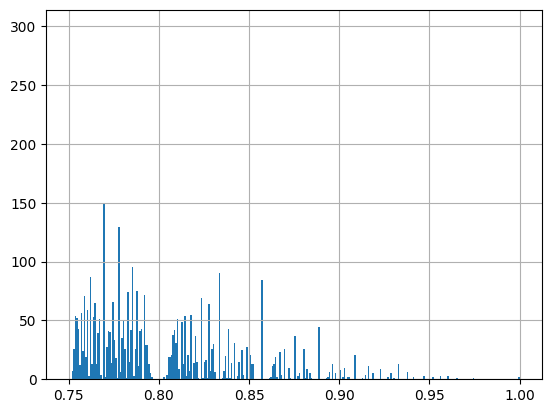

In [7]:
df_results['precision'].hist(bins=300)

<Axes: >

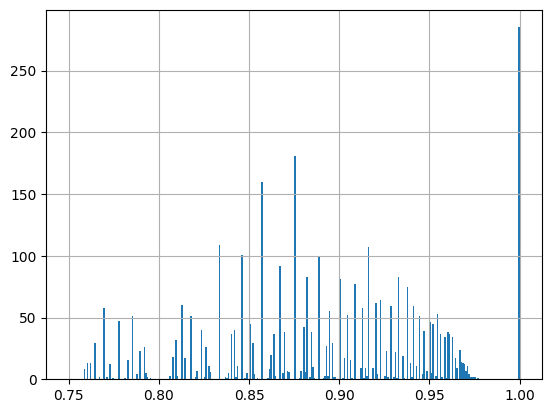

In [8]:
df_results['recall'].hist(bins=300)

<Axes: >

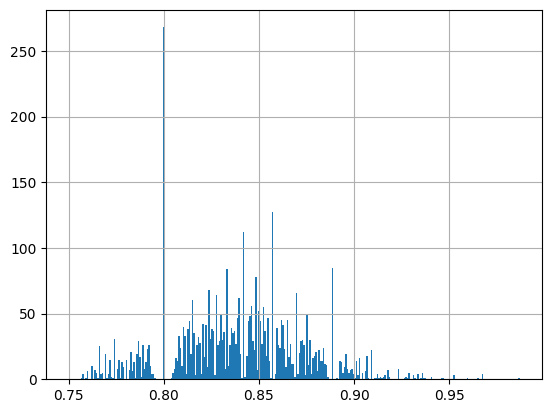

In [9]:
df_results['f1'].hist(bins=300)